In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

            venda      estoque       preco
count  937.000000   937.000000  937.000000
mean    90.533618  1608.258271    1.592572
std     80.682089  1356.691877    0.529502
min      0.000000     0.000000    0.000000
25%     33.000000   794.000000    1.290000
50%     76.000000  1348.000000    1.390000
75%    127.000000  1964.000000    1.890000
max    542.000000  7228.000000    2.980000
Valores nulos:
 venda      0
estoque    0
preco      0
dtype: int64
Datas duplicadas? False


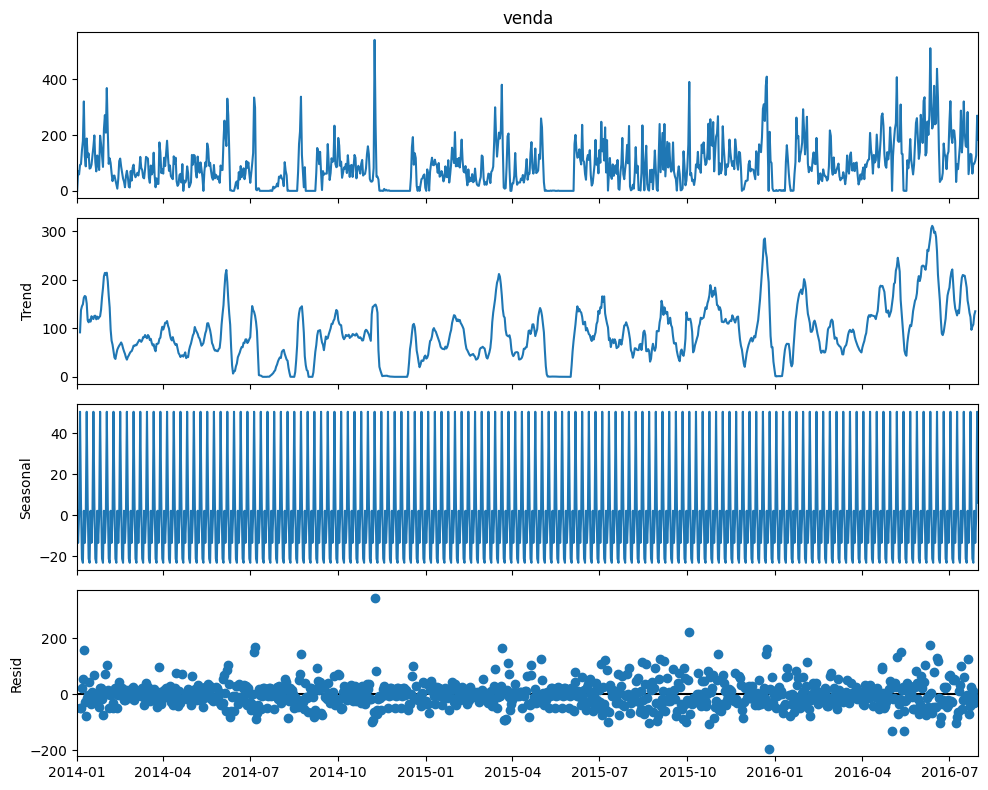

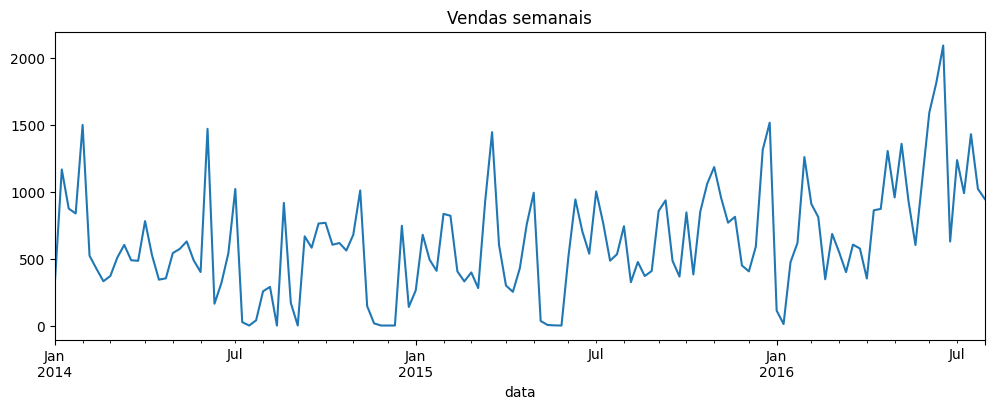

C:\Users\iuryc\AppData\Local\Temp\ipykernel_17448\3012699198.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['estoque'].resample('M').mean().plot(title='Estoque médio mensal')


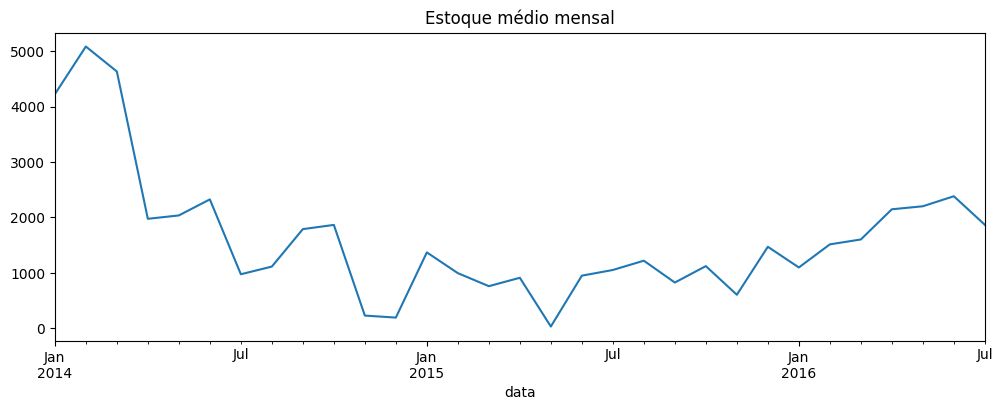

In [2]:
# 1. Análise Exploratória de Dados (EDA) e Pré-processamento

df = pd.read_csv('mock_kaggle.csv', parse_dates=['data'])
df.set_index('data', inplace=True)
df = df.sort_index()

print(df.describe())
print("Valores nulos:\n", df.isna().sum())
print("Datas duplicadas?", not df.index.is_unique)

df = df.asfreq('D')
df['venda'] = df['venda'].interpolate(method='time')

decomp = seasonal_decompose(df['venda'], model='additive', period=7)
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
df['venda'].resample('W').sum().plot(title='Vendas semanais')
plt.show()

plt.figure(figsize=(12,4))
df['estoque'].resample('M').mean().plot(title='Estoque médio mensal')
plt.show()


In [4]:
# 2. ENGENHARIA DE FEATURES

#Lags e diferenças
df['venda_lag1'] = df['venda'].shift(1)
df['venda_lag7'] = df['venda'].shift(7)
df['venda_diff1'] = df['venda'].diff(1)

# Variáveis de calendário
df['dayofweek'] = df.index.dayofweek      # 0=segunda ... 6=domingo
df['month']     = df.index.month
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_month_start'] = df.index.is_month_start.astype(int)

#Mudança de preço e elasticidade
df['preco_change'] = df['preco'].pct_change()
df['preco_diff']   = df['preco'].diff()

#Indicadores de estoque
df['estoque_media_7d'] = df['estoque'].rolling(7).mean()
df['days_of_stock']    = df['estoque'] / (df['venda'].rolling(7).mean() + 1e-6)

#Limpeza final: remover linhas com NaNs gerados por lags/rolling
df_feat = df.dropna().copy()

print("\nDataFrame final de features:")
print(df_feat.head())



DataFrame final de features:
            venda  estoque  preco  venda_lag1  venda_lag7  venda_diff1  \
data                                                                     
2014-01-08  321.0   4104.0   1.29       179.0         0.0        142.0   
2014-01-09  125.0   4459.0   1.09       321.0        70.0       -196.0   
2014-01-10   88.0   5043.0   1.09       125.0        59.0        -37.0   
2014-01-11  188.0   5239.0   1.09        88.0        93.0        100.0   
2014-01-12  121.0   5118.0   1.09       188.0        96.0        -67.0   

            dayofweek  month  is_month_end  is_month_start  preco_change  \
data                                                                       
2014-01-08          2      1             0               0      0.000000   
2014-01-09          3      1             0               0     -0.155039   
2014-01-10          4      1             0               0      0.000000   
2014-01-11          5      1             0               0      0.00000

C:\Users\iuryc\AppData\Local\Temp\ipykernel_17448\75268130.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['preco_change'] = df['preco'].pct_change()


#### Modelagem com ARIMA

                               SARIMAX Results                                
Dep. Variable:                  venda   No. Observations:                  913
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5032.467
Date:                Mon, 05 May 2025   AIC                          10070.934
Time:                        09:57:17   BIC                          10085.381
Sample:                    01-01-2014   HQIC                         10076.449
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5979      0.023     26.209      0.000       0.553       0.643
ma.L1         -0.9809      0.007   -142.849      0.000      -0.994      -0.967
sigma2      3626.5704     88.531     40.964      0.0

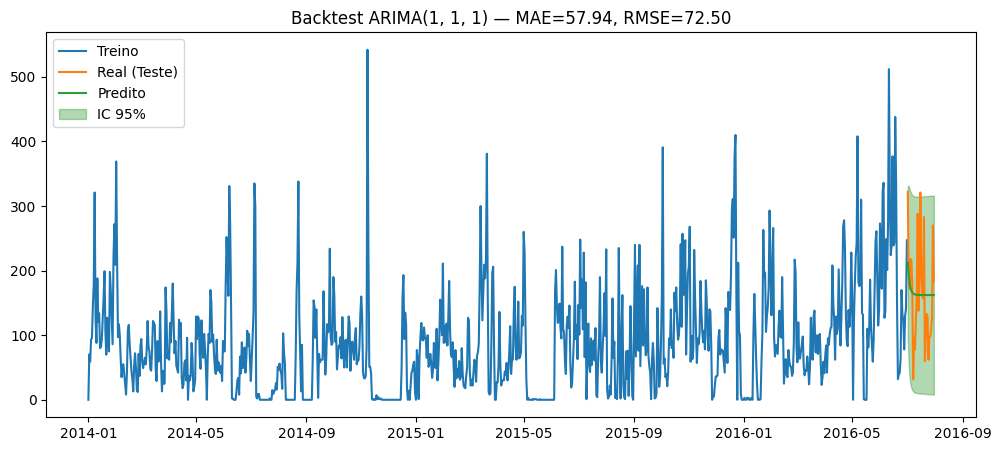

In [6]:
#Defimição de horizonte de previsão
horizon = 30  
series = df['venda']  # sua série original

train = series.iloc[:-horizon]
test  = series.iloc[-horizon:]

#ajuste do arima
order = (1, 1, 1)
model = ARIMA(train, order=order)
res   = model.fit()

print(res.summary())


fc = res.get_forecast(steps=horizon)
pred = fc.predicted_mean
ci   = fc.conf_int()

# Avaliação de desempenho e plotagem
mae  = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
print(f"MAE no backtest (últimos {horizon} dias): {mae:.2f}")
print(f"RMSE no backtest (últimos {horizon} dias): {rmse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Treino')
plt.plot(test.index, test,   label='Real (Teste)')
plt.plot(pred.index, pred,   label='Predito')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='green', alpha=0.3, label='IC 95%')
plt.legend()
plt.title(f'Backtest ARIMA{order} — MAE={mae:.2f}, RMSE={rmse:.2f}')
plt.show()


#### Modelagem com SARIMA

In [7]:
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

In [8]:
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             venda   No. Observations:                  913
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -4917.504
Date:                           Mon, 05 May 2025   AIC                           9845.007
Time:                                   09:57:24   BIC                           9869.042
Sample:                               01-01-2014   HQIC                          9854.187
                                    - 07-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7261      0.028     26.366      0.000       0.672       0.780
ma.L1         -0.1002      0.038     -2.605

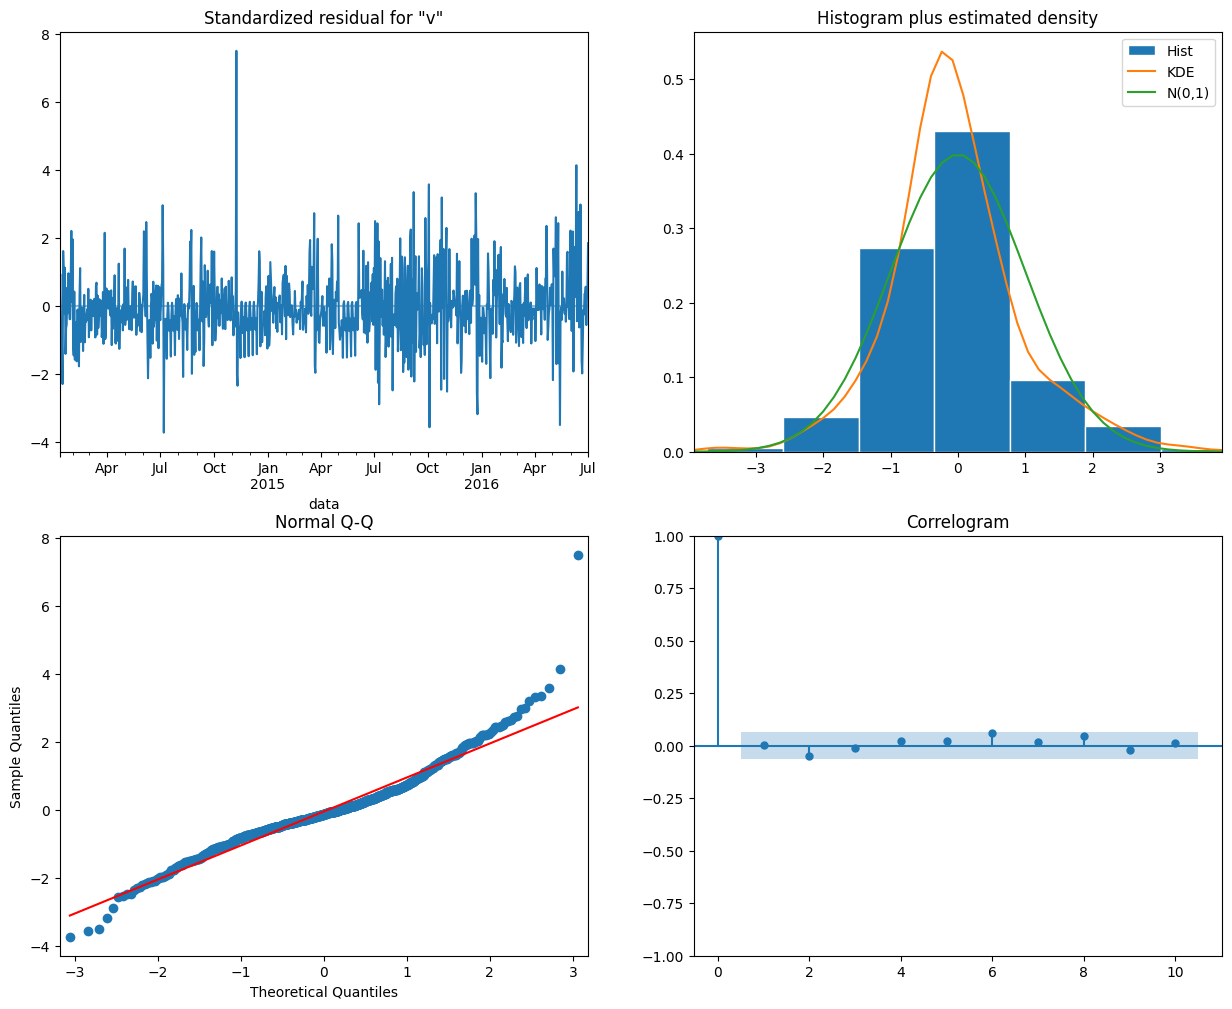

In [9]:
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

MAE SARIMA no backtest (últimos 30 dias): 58.46
RMSE SARIMA no backtest (últimos 30 dias): 71.68


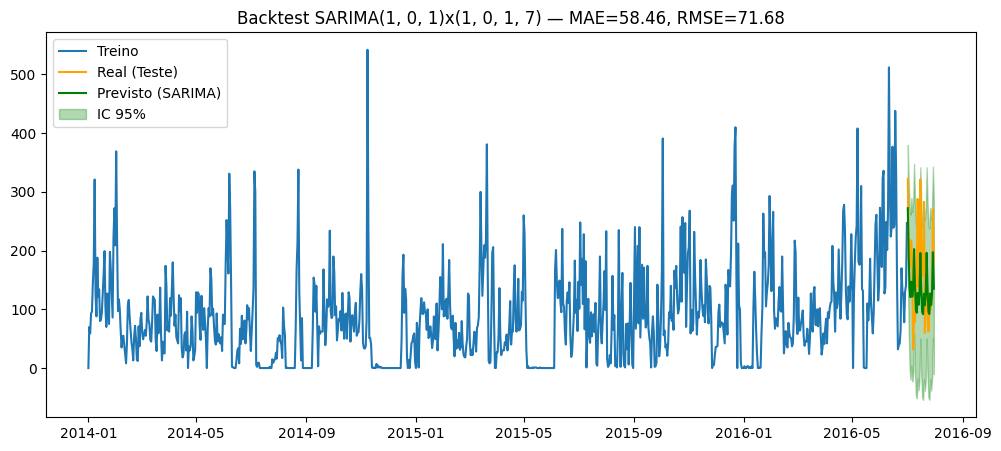

In [10]:
#Previsão no backtest
sarima_order= (1, 0, 1)
seasonal_order=(1, 0, 1, 7)
pred = sarima_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
pred_conf = pred.conf_int()

# Calculo de metricas e plotagem
mae_sarima  = mean_absolute_error(test, pred_mean)
rmse_sarima = np.sqrt(mean_squared_error(test, pred_mean))
print(f"MAE SARIMA no backtest (últimos {horizon} dias): {mae_sarima:.2f}")
print(f"RMSE SARIMA no backtest (últimos {horizon} dias): {rmse_sarima:.2f}")


plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Treino')
plt.plot(test.index,  test, label='Real (Teste)', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Previsto (SARIMA)', color='green')
plt.fill_between(pred_conf.index,
                 pred_conf.iloc[:, 0],
                 pred_conf.iloc[:, 1],
                 color='green',
                 alpha=0.3,
                 label='IC 95%')
plt.legend(loc='upper left')
plt.title(f'Backtest SARIMA{sarima_order}x{seasonal_order} — '
          f'MAE={mae_sarima:.2f}, RMSE={rmse_sarima:.2f}')
plt.show()